In [1]:
from FFNN import NeuralNetwork, train_network, train_network_momentum, train_network_stocastic_momentum, train_network_SRMSprop, train_network_stocastic_ADAM
import copy
import activation_functions as af
import cost_functions as cf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Generate data
Using the same function and seed for generating data as in project 1.

In [2]:
def generate_data(n, noise = True):
    # Fixed seed value to ensure consisten results across runs
    seed = 42
    np.random.seed(seed)
    # Creating an array with equally spaced data
    x = np.linspace(-1, 1, n)
    # Runges equation with noise
    if noise:
        y = 1 / (1 + 25*x**2) +  np.random.normal(0, 0.1, size=n)
    else:
        y = 1 / (1 + 25*x**2)
    return x, y

In [3]:
n = 50
x, y = generate_data(n)
x = x.reshape(-1,1)
y = y.reshape(-1,1)

### Visualizing the data we are working with

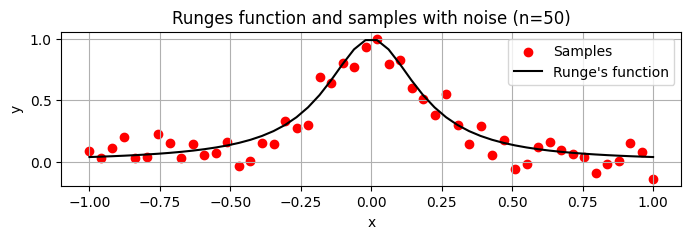

In [4]:
plt.figure(figsize=(8, 2))
plt.scatter(x, y, color='red', linewidth=1, label='Samples')
plt.plot(x, 1/(1+25*x**2), color = 'k', label = "Runge's function")
plt.title("Runges function and samples with noise (n=50)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### Train, test split with validation sat

In [5]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Scaling inputs

In [6]:
# Scale inputs
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test  = scaler.transform(X_test)

### Training two neural networks
1. One that has 1 hidden layer with 50 nodes.
2. One that has 2 hidden layers with 50 and 100 nodes respectively.

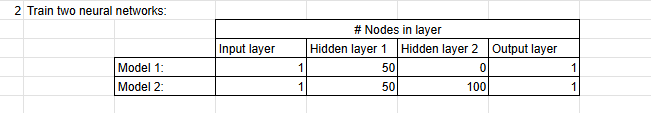

1 Hidden layer with 50 nodes:
MSE: 0.06131

2 Hidden layers with 50 and 100 nodes:
MSE : 0.01461


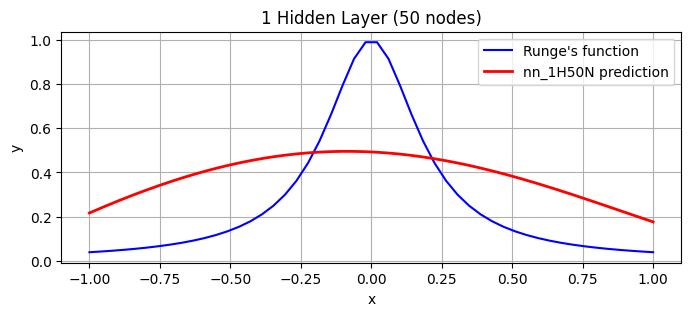

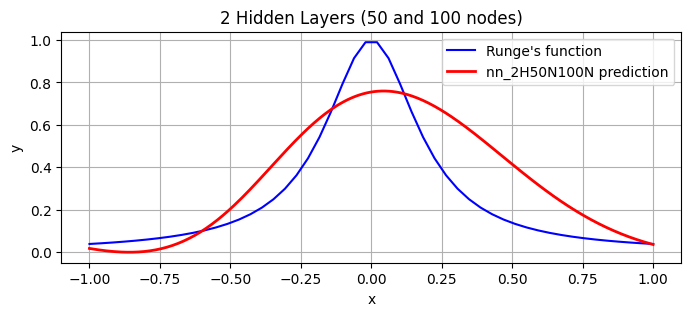

In [7]:
# Creating the neural networks
nn_1H50N = NeuralNetwork(
    network_input_size=x_train.shape[1],
    layer_output_sizes=[50, 1],
    activation_funcs=[af.sigmoid, af.identity],
    cost_func=cf.mse)

nn_2H50N100N = NeuralNetwork(
    network_input_size=x_train.shape[1],
    layer_output_sizes=[50, 100, 1],
    activation_funcs=[af.sigmoid, af.sigmoid, af.identity],
    cost_func=cf.mse)

# Training the neural network
train_network_stocastic_momentum(nn_1H50N, x_train, y_train, eta=0.01, epochs=100)
train_network_stocastic_momentum(nn_2H50N100N, x_train, y_train, eta=0.01, epochs=100)

# Predicting outputs
prediction_1 = nn_1H50N.predict(x_test)
prediction_2 = nn_2H50N100N.predict(x_test)

# Computing the MSE on unscaled data
mse_1layer = cf.mse(y_test, prediction_1)
mse_2layers = cf.mse(y_test, prediction_2)


print("1 Hidden layer with 50 nodes:\n=========================")
print(f"MSE: {mse_1layer:.5f}\n")

print("2 Hidden layers with 50 and 100 nodes:\n=========================")
print(f"MSE : {mse_2layers:.5f}")

# Prediction plot
x_plot = np.linspace(-1, 1, 300).reshape(-1, 1)

plt.figure(figsize=(8, 3))
plt.plot(x, 1 / (1 + 25 * x**2), label="Runge's function", color="blue")
plt.plot(x_plot, nn_1H50N.predict(x_plot), color="red", linewidth=2, label="nn_1H50N prediction")
plt.title("1 Hidden Layer (50 nodes)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(x, 1 / (1 + 25 * x**2), label="Runge's function", color="blue")
plt.plot(x_plot, nn_2H50N100N.predict(x_plot),color="red", linewidth=2, label="nn_2H50N100N prediction")
plt.title("2 Hidden Layers (50 and 100 nodes)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


### Hyperparameter tuning optimizer and learning rate

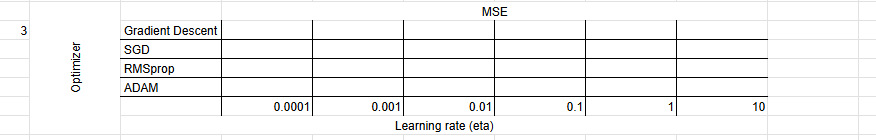

c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: overflow encountered in square
  lambda ans, x, y: unbroadcast_f(y, lambda g: -g * x / y**2),
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
c:\Users\eirik\Documents\FYSSTK3155\Project2_FYSSTK3155-4155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:160: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp, lambda ans, x: lambda g: ans * g)


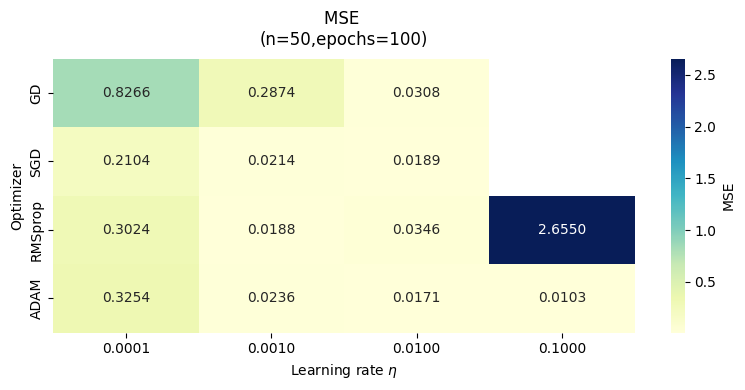

Lowest MSE: 0.010336
Optimizer: ADAM
Learning rate ($\eta$): {best_eta:.4e}


In [8]:
# Parameters we are tuning 
optimizers = [train_network, # Gradient descent
            train_network_stocastic_momentum, # Stochastic gradient descent with momentum
            train_network_SRMSprop, # RMSProp
            train_network_stocastic_ADAM] # ADAM

learning_rates = np.logspace(-4, -1, num=4)
epochs = 100

# Empty list of Mean Squared Errors which we will use for the heatmap
mse_matrix = []

# Iterating through all the different combinations of optimizers and learning rates, and calculate the corresponding MSE.
for optimizer in optimizers:
    mse_row = []
    for eta in learning_rates:
        np.random.seed(42)
        nn = NeuralNetwork(
            x.shape[1],
            [50, 100, 1],
            [af.sigmoid, af.sigmoid, af.identity],
            cf.mse)

        optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
        predictions = nn.predict(x_test)
        
        mse = cf.mse(y_test, predictions)
        mse_row.append(mse)

    mse_matrix.append(mse_row)

mse_matrix = np.array(mse_matrix)

# Labels
optimizer_labels = ["GD", "SGD", "RMSprop", "ADAM"]

# Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(mse_matrix, annot=True, fmt=".4f", cmap="YlGnBu",xticklabels=[f"{lr:.4f}" for lr in learning_rates],yticklabels=optimizer_labels,cbar_kws={"label": "MSE"})
plt.title(f"MSE \n(n={50},epochs={epochs})", fontsize=12, pad=10)
plt.xlabel(r"Learning rate $\eta$")
plt.ylabel("Optimizer")
plt.tight_layout()
plt.show()

# Finding the optimizer and learning rate that produces that lowest MSE
min_idx = np.unravel_index(np.nanargmin(mse_matrix), mse_matrix.shape)
best_optimizer = optimizer_labels[min_idx[0]]
best_eta = learning_rates[min_idx[1]]
best_mse = mse_matrix[min_idx]

print(f"Lowest MSE: {best_mse:.6f}")
print(f"Optimizer: {best_optimizer}")
print(r"Learning rate ($\eta$): {best_eta:.4e}")

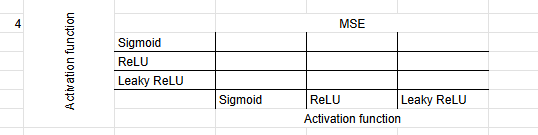

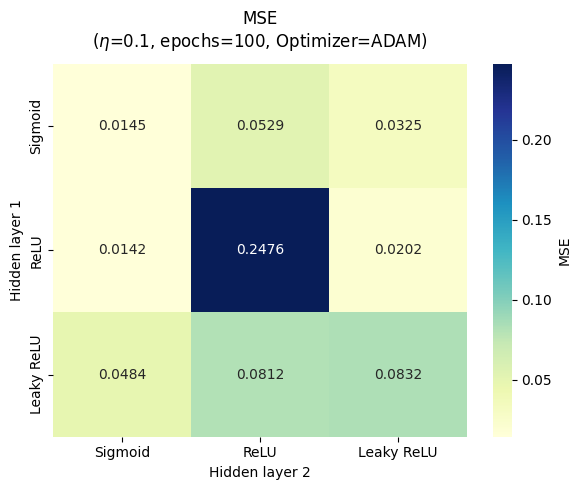

In [9]:
optimizer = train_network_stocastic_ADAM
eta = 1e-1
epochs = 100

# Parameters we are tuning
activation_functions = [af.sigmoid, af.ReLU, af.leaky_ReLU]

# Empty list of Mean Squared Errors which we will use for the heatmap
mse_matrix = []

# Iterating through all the different combinations of activations functions for two hidden layers, and calculate the corresponding MSE.
for hidden1 in activation_functions:
    mse_row = []
    for hidden2 in activation_functions:
        nn = NeuralNetwork(
            x.shape[1],
            [50, 100, 1],
            [hidden1, hidden2, af.identity],
            cf.mse)

        optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
        predictions = nn.predict(x_test)
        
        mse = cf.mse(y_test, predictions)
        mse_row.append(mse)

    mse_matrix.append(mse_row)

mse_matrix = np.array(mse_matrix)

# Labels
activation_labels = ["Sigmoid", "ReLU", "Leaky ReLU"]

plt.figure(figsize=(6, 5))
sns.heatmap(mse_matrix,annot=True, fmt=".4f", cmap="YlGnBu", xticklabels=activation_labels,yticklabels=activation_labels,cbar_kws={"label": "MSE"})

plt.title(f"MSE\n($\\eta$={eta}, epochs={epochs}, Optimizer=ADAM)", fontsize=12, pad=12)
plt.xlabel("Hidden layer 2")
plt.ylabel("Hidden layer 1")
plt.tight_layout()
plt.show()


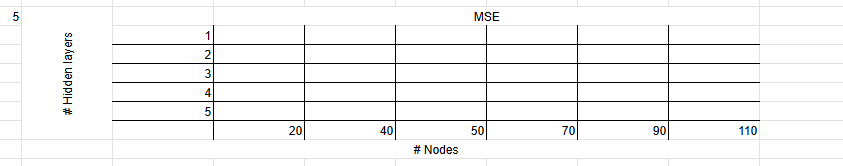

In [10]:
hiddenlayer_combinations = [
    [50, 1], # 1 hidden layer
    [50, 50, 1], # 2 hidden layers
    [100, 50, 1],
    [100, 100, 1],
    [50, 50, 50, 1], # 3 hidden layers
    [100, 50, 50, 1],
    [100, 100, 50, 1],
    [100, 100, 100, 1],
    [100, 100, 100, 1],
    [50, 50, 50, 50, 1], # 4 hidden layers
    [100, 50, 50, 50, 1],
    [100, 100, 50, 50, 1],
    [100, 100, 100, 50, 1],
    [100, 100, 100, 100, 1],
]

for hiddenlayer in hiddenlayer_combinations:
    # Using sigmoid is activation function on all the hidden layers, except the output which uses the identity function.
    nn = NeuralNetwork(x.shape[1], hiddenlayer, [af.sigmoid]* (len(hiddenlayer)-1) + [af.identity], cf.mse)
    train_network_stocastic_ADAM(nn, x_train, y_train, eta=1e-2, epochs=100)
    mse = cf.mse(y_test, nn.predict(x_test))
    print(hiddenlayer, "MSE:", mse)


[50, 1] MSE: 0.04662649873774454
[50, 50, 1] MSE: 0.021402078511022715
[100, 50, 1] MSE: 0.020356899761543278
[100, 100, 1] MSE: 0.015407990945533693
[50, 50, 50, 1] MSE: 0.0438877150393279
[100, 50, 50, 1] MSE: 0.015614323147578175
[100, 100, 50, 1] MSE: 0.009151170329398134
[100, 100, 100, 1] MSE: 0.008733850805971312
[100, 100, 100, 1] MSE: 0.007908533269828771
[50, 50, 50, 50, 1] MSE: 0.011861889583311932
[100, 50, 50, 50, 1] MSE: 0.008892768622096401
[100, 100, 50, 50, 1] MSE: 0.008757680911274468
[100, 100, 100, 50, 1] MSE: 0.008836419932133415
[100, 100, 100, 100, 1] MSE: 0.011132907461757388


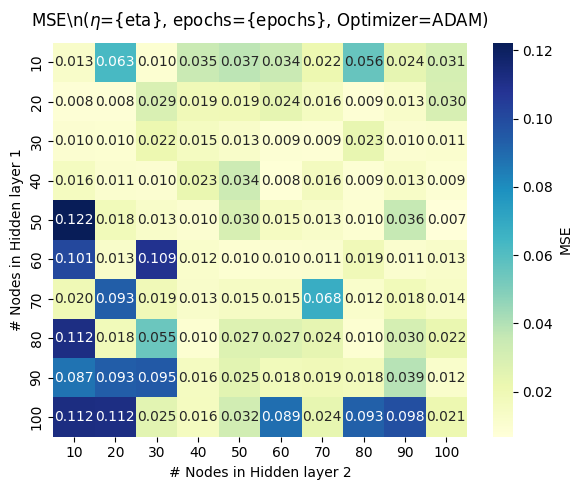

In [11]:
optimizer = train_network_stocastic_ADAM
eta = 1e-1
epochs = 100
activation_functions = [af.sigmoid, af.sigmoid, af.identity]
hidden1_nodes= [10,20,30,40,50,60,70,80,90,100]
hidden2_nodes= [10,20,30,40,50,60,70,80,90,100]

# Empty list of Mean Squared Errors which we will use for the heatmap
mse_matrix = []

# Iterating through all the different combinations of activations functions for two hidden layers, and calculate the corresponding MSE.
for hidden1 in hidden1_nodes:
    mse_row = []
    for hidden2 in hidden2_nodes:
        nn = NeuralNetwork(
            x.shape[1],
            [hidden1, hidden2, 1],
            activation_functions,
            cf.mse)
        
        optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
        predictions = nn.predict(x_test)
        
        mse = cf.mse(y_test, predictions)
        mse_row.append(mse)

    mse_matrix.append(mse_row)

mse_matrix = np.array(mse_matrix)

label1 = ["10","20","30","40","50","60","70","80","90","100"]
plt.figure(figsize=(6, 5))
sns.heatmap(mse_matrix,annot=True, fmt=".3f", cmap="YlGnBu", xticklabels=label1,yticklabels=label1,cbar_kws={"label": "MSE"})

plt.title(r"MSE\n($\eta$={eta}, epochs={epochs}, Optimizer=ADAM)", fontsize=12, pad=12)
plt.xlabel("# Nodes in Hidden layer 2")
plt.ylabel("# Nodes in Hidden layer 1")
plt.tight_layout()
plt.show()


In [12]:
# Find indices of the lowest MSE
min_idx = np.unravel_index(np.nanargmin(mse_matrix), mse_matrix.shape)

# Extract best combination
best_hidden1 = hidden1_nodes[min_idx[0]]
best_hidden2 = hidden2_nodes[min_idx[1]]
best_mse = mse_matrix[min_idx]

# Print results
print(f"Lowest MSE: {best_mse:.6f}")
print(f"# Nodes in Hidden Layer 1: {best_hidden1}")
print(f"# Nodes in Hidden Layer 2: {best_hidden2}")

Lowest MSE: 0.006795
# Nodes in Hidden Layer 1: 50
# Nodes in Hidden Layer 2: 100


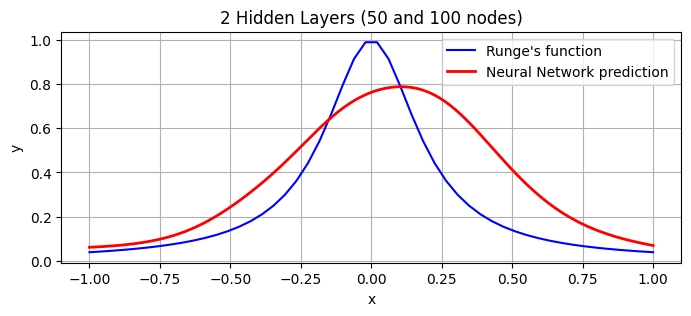

In [13]:
optimizer = train_network_stocastic_ADAM
eta = 1e-1
epochs = 100
activation_functions = [af.sigmoid, af.sigmoid, af.identity]

nn = NeuralNetwork(
    x.shape[1],
    [best_hidden1, best_hidden2, 1],
    activation_functions,
    cf.mse)

optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
predictions = nn.predict(x_test)

# Prediction plot
x_plot = np.linspace(-1, 1, 300).reshape(-1, 1)

plt.figure(figsize=(8, 3))
plt.plot(x, 1 / (1 + 25 * x**2), label="Runge's function", color="blue")
plt.plot(x_plot, nn.predict(x_plot),color="red", linewidth=2, label="Neural Network prediction")
plt.title(f"2 Hidden Layers ({best_hidden1} and {best_hidden2} nodes)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


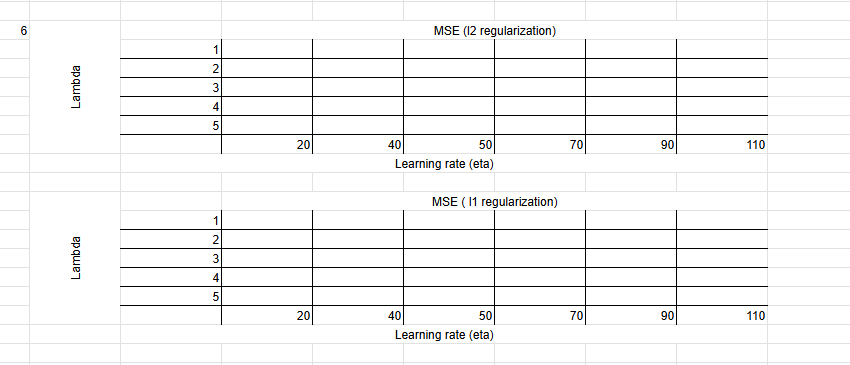